# Анализ процесса выплавки стали

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels

In [2]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(statsmodels.__version__)

1.3.5
1.22.3
0.11.2
0.13.1


### Загрузка данных

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 57 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   melt_id      60 non-null     object 
 1   furnace      60 non-null     object 
 2   n_items      60 non-null     int64  
 3   n_defects    60 non-null     int64  
 4   melt_volume  60 non-null     float64
 5   FeSiMn       29 non-null     float64
 6   FeMn         8 non-null      float64
 7   FeSi         47 non-null     float64
 8   CaSi         60 non-null     float64
 9   FeTi         60 non-null     float64
 10  AB           60 non-null     float64
 11  C_0          60 non-null     float64
 12  Mn_0         60 non-null     float64
 13  Si_0         30 non-null     float64
 14  P_0          60 non-null     float64
 15  S_0          60 non-null     float64
 16  Cr_0         60 non-null     float64
 17  Ni_0         28 non-null     float64
 18  Cu_0         28 non-null     float64
 19  C_1       

### Описание признаков

* melt_id – номер плавки
* furnace – плавильная печь: open-hearth – мартеновская печь; EAF – электродуговая печь
* n_items – общее число отливок с одной плавки
* n_defects – число забракованных отливок с одной плавки
* melt_volume – объем жидкой стали в печи
* FeSiMn, FeMn, FeSi, CaSi, FeTi, AB – расход соответствующих ферросплавов
    
| Сплав  | Марка  | C | Mn | Si  | Ca | Ti | Al | 
| ------ | ------ | - | -- | --  | -- | -- | -- |
| FeSiMn | МнС-17 |   | 70 | 17  |    |    |    |
| FeMn   | ФМн-78 | 6 | 78 |     |    |    |    |
| FeSi   | ФС-45  |   |    | 45  |    |    |    |
| CaSi   | СК-15  |   |    | 53  | 18 |    |    |
| FeTi   | ФТи-35 |   |    | 4.5 |    | 30 |    |
| AB     | АВ-87  |   |    |     |    |    | 87 |

* C, Mn, Si, P, S, Cr, Ni, Cu, Ti, Al – химический состав<br/>
Индекс – тип пробы:
    - 0 – по расплаву – после расплавления шихты
    - 1 – перед раскислением – по окончании кипения и десульфурации
    - 2 – перед выпуском – после предварительного раскисления в печи и доводки по химическому составу
    - 3 – ковшевая – после выпуска из печи, окончательного раскисления и модифицирования в ковше
    - без индекса – маркировочная – во время разливки металла с середины ковша через 20-30 минут после ковшевой пробы (образцы для механических испытаний изготовлены из этих проб)
* yield_str – предел текучести
* tensile_str – предел прочности
* elongation – относительное удлинение
* narrowing – относительное сужение
* KCU, KCV – ударная вязкость с U-образным и V-образным надрезом (по 2 образца)

## Распределение элементов в ковшевой и маркировочной пробах

In [5]:
samples = pd.DataFrame(
    np.vstack((
        data.loc[:,'C':'Al'].assign(sample='mark', furnace=data.furnace, melt_id=data.melt_id)\
        .drop(['Ni','Cu'], axis=1).values,
        data.filter(like='_3').assign(sample='ladle', furnace=data.furnace, melt_id=data.melt_id)\
        .values
    )), 
    columns=['C','Mn','Si','P','S','Cr','Ti','Al','sample','furnace','melt_id'])\
.dropna().convert_dtypes()

print(samples.drop('melt_id', axis=1).sample(5))

       C    Mn    Si      P      S    Cr     Ti     Al sample      furnace
25  0.23  1.31   0.4  0.023  0.028  0.12  0.004  0.045   mark  open-hearth
13  0.19   1.1  0.38  0.021   0.03   0.1  0.003  0.034   mark  open-hearth
85  0.24   1.4  0.35  0.027   0.03  0.11  0.006   0.06  ladle  open-hearth
89   0.2   1.3  0.37  0.023  0.029  0.11  0.004   0.06  ladle  open-hearth
77  0.22   1.2  0.28  0.027   0.03   0.1  0.004   0.03  ladle  open-hearth


Здесь sample – тип пробы: mark – маркировочная; ladle – ковшевая.

In [6]:
def histplot(X, y, bins=12, ncols=4, figsize=(16,8)):
    plt.rcParams['font.size'] = 11
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    nrows = X.shape[1]//ncols + 1
    
    for idx, feature in enumerate(X.columns):       
        plt.subplot(nrows, ncols, idx+1)        
        ax = sns.histplot(data=X.assign(sample=y), x=feature, hue='sample', bins=bins, multiple='stack', kde=True)    
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')

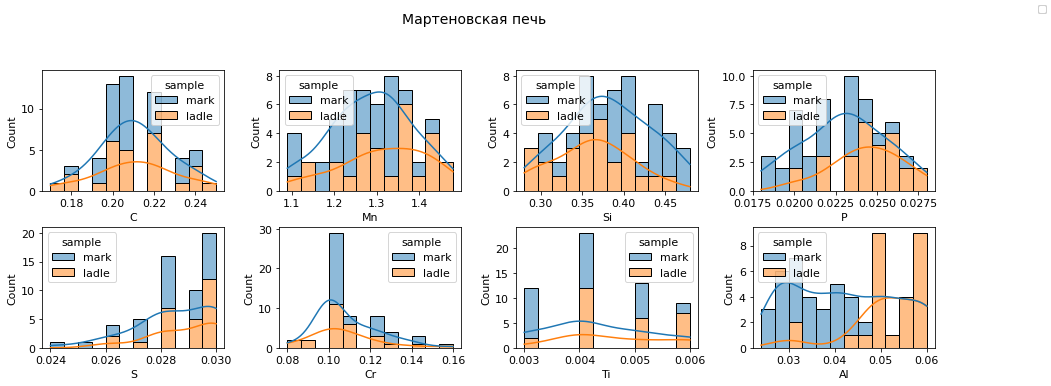

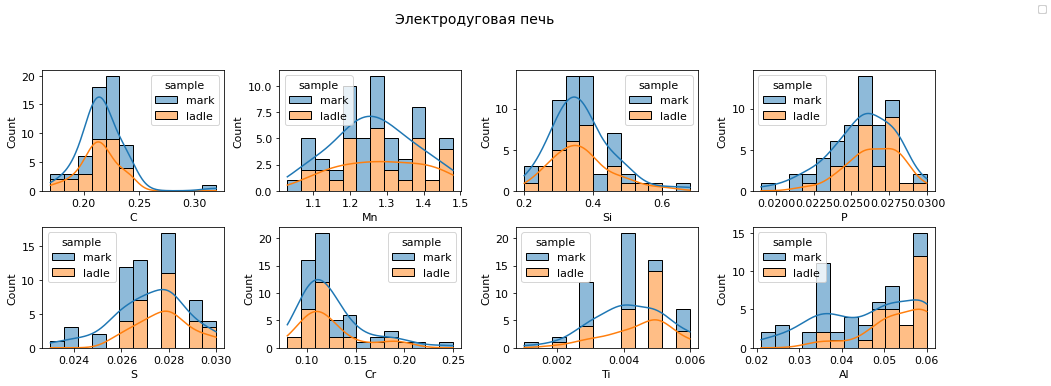

In [7]:
for furnace in samples.furnace.unique():
    frame = samples.query('furnace == @furnace')
    X = frame.drop(['melt_id', 'sample', 'furnace'], axis=1)
    y = frame['sample']
    histplot(X, y)
    plt.suptitle('Мартеновская печь' if furnace == 'open-hearth' else 'Электродуговая печь', fontsize=14)

Распределение многих элементов отличается от нормального. В данных имеются выбросы.

In [8]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

def check_outliers(x):
    '''
    Return outlier indexes using IRQ
    '''
    q1, q3 = np.quantile(x, 0.25), np.quantile(x, 0.75)
    iqr = stats.iqr(x)
    return ((x < (q1-1.5*iqr)) | (x > (q3+1.5*iqr)))

def diff_test(a, b):
    '''
    Calculates the T-test for the means of two independent samples or the Mann-Whitney U rank test 
    on two independent samples depends on the data distribution and outliers present
    '''
    outliers = list(map(lambda x: any(check_outliers(x)), [a, b]))
    p = [stats.shapiro(a).pvalue, stats.shapiro(b).pvalue]
    test = 'Mannwhitneyu' if any(np.hstack([np.array(p) < 0.05, outliers])) else 'Ttest'
    res = stats.ttest_ind(a, b) if test == 'Ttest' else stats.mannwhitneyu(a, b)
    return res + (test,)

In [9]:
res = []

for furnace in samples.furnace.unique():
    for var in samples.drop(['melt_id', 'furnace', 'sample'], axis=1).columns:
        stat, p, test = diff_test(samples.query('furnace == @furnace & sample == "mark"')[var].to_list(), 
                                  samples.query('furnace == @furnace & sample == "ladle"')[var].to_list())
        res.append([furnace, var, test, stat, p])
        
res = pd.DataFrame(res, columns=['furnace', 'feature', 'test', 'stat', 'p_value'])
reject, p_adjust, a1, a2 = multipletests(res.p_value, alpha = 0.05, method = 'fdr_bh')
res = res.assign(p_adjust=p_adjust, null_reject=reject)

with pd.option_context('precision', 2):
    print(res.sort_values(['null_reject', 'furnace'], ascending=False))

        furnace feature          test    stat   p_value  p_adjust  null_reject
1   open-hearth      Mn         Ttest   -2.29  2.58e-02  4.59e-02         True
2   open-hearth      Si         Ttest    2.95  4.70e-03  1.88e-02         True
3   open-hearth       P         Ttest   -4.56  2.87e-05  1.53e-04         True
6   open-hearth      Ti  Mannwhitneyu  264.00  1.85e-02  4.24e-02         True
7   open-hearth      Al  Mannwhitneyu   42.50  6.68e-09  1.07e-07         True
11          EAF       P  Mannwhitneyu  261.50  7.86e-03  2.10e-02         True
12          EAF       S  Mannwhitneyu  259.50  6.63e-03  2.10e-02         True
14          EAF      Ti  Mannwhitneyu  291.50  2.42e-02  4.59e-02         True
15          EAF      Al  Mannwhitneyu  135.00  4.89e-06  3.92e-05         True
0   open-hearth       C  Mannwhitneyu  383.00  7.26e-01  7.75e-01        False
4   open-hearth       S  Mannwhitneyu  301.00  8.60e-02  1.38e-01        False
5   open-hearth      Cr  Mannwhitneyu  444.00  5.08e

На уровне значимости α = 0.05 концентрация Mn, Si, P, Ti и Al в ковшевой и маркировочной пробах значимо различается в стали мартеновской плавки, концентрация P, S, Ti и Al – в стали электродуговой плавки. Для остальных элементов полученных данных не достаточно, чтобы подтвердить значимость различий. 

## Доля брака в зависимости от типа печи

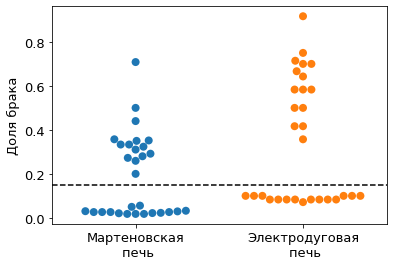

In [10]:
data = data.assign(defect_rate = data.n_defects / data.n_items)

plt.rcParams['font.size'] = 13
plt.figure(figsize=(6,4))

sns.swarmplot(x='furnace', y='defect_rate', 
              data=data.replace({'open-hearth': 'Мартеновская\n печь', 'EAF': 'Электродуговая\n печь'}), 
              size=8)
plt.axhline(0.15, ls='--', c='k')
plt.xlabel('')
plt.ylabel('Доля брака');

При плавке стали в мартеновской печи доля брака в среднем несколько ниже. Имеются плавки с долей брака близкой к нулю.

In [11]:
data['defect_risk'] = data['defect_rate'].apply(lambda x: 'high' if x > 0.15 else 'low')

Новая переменная определяет плавки с высокой и низкой долей брака.

## Шансы брака в зависимости от состава металла в ковше

In [12]:
frame = samples.merge(data[['melt_id', 'defect_risk']].replace({'defect_risk': {'low': 0, 'high': 1}}), 
                      on='melt_id').drop('melt_id', axis=1)
float64_cols = list(frame.select_dtypes(include='float64'))
frame[float64_cols] = frame[float64_cols].astype('float32')
frame[['sample', 'furnace']] = frame[['sample', 'furnace']].astype('object')

print(frame.sample(5))

       C    Mn    Si      P      S    Cr     Ti     Al sample      furnace  \
20  0.21  1.32  0.44  0.024  0.030  0.14  0.005  0.031   mark  open-hearth   
27  0.23  1.35  0.36  0.026  0.029  0.11  0.004  0.060  ladle  open-hearth   
30  0.20  1.25  0.35  0.024  0.027  0.12  0.005  0.039   mark  open-hearth   
2   0.18  1.13  0.31  0.026  0.030  0.11  0.004  0.050  ladle  open-hearth   
85  0.21  1.10  0.35  0.027  0.029  0.10  0.004  0.033   mark          EAF   

    defect_risk  
20            0  
27            0  
30            1  
2             0  
85            0  


In [13]:
import rpy2
print(rpy2.__version__)
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

3.5.2


In [14]:
with localconverter(ro.default_converter + pandas2ri.converter):
    ro.r.assign('frame', ro.conversion.py2rpy(frame))

In [15]:
ro.r('fit_full <- glm("defect_risk ~ .", data = frame, family="binomial")')
print(ro.r('summary(fit_full)'))


Call:
glm(formula = "defect_risk ~ .", family = "binomial", data = frame)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.10840  -0.96491  -0.05367   1.05825   1.82785  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          20.1418     6.2349   3.231 0.001236 ** 
C                    -6.2260    12.7507  -0.488 0.625350    
Mn                    0.3626     2.5674   0.141 0.887680    
Si                    1.5185     3.4429   0.441 0.659168    
P                   -67.1761   100.3362  -0.670 0.503171    
S                  -699.8392   185.6894  -3.769 0.000164 ***
Cr                    3.2613     9.2984   0.351 0.725785    
Ti                  -27.8304   221.9627  -0.125 0.900220    
Al                   19.4532    28.7889   0.676 0.499218    
samplemark           -0.4809     0.6513  -0.738 0.460282    
furnaceopen-hearth    0.9160     0.6013   1.523 0.127652    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘

По значениям статистической ошибки первого рода для коэффициентов регрессии можно видеть, что ни один параметр, за исключением S, не вносит значимого вклада в модель. 

In [16]:
ro.r('fit_reduced <- glm(defect_risk ~ S, data = frame, family="binomial")')
print(ro.r('summary(fit_reduced)'))


Call:
glm(formula = defect_risk ~ S, family = "binomial", data = frame)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.033  -1.008  -0.184   1.045   1.636  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   13.790      3.852   3.580 0.000344 ***
S           -494.142    137.592  -3.591 0.000329 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 160.81  on 115  degrees of freedom
Residual deviance: 145.32  on 114  degrees of freedom
AIC: 149.32

Number of Fisher Scoring iterations: 4




В сокращенной модели коэффициенты регрессии статистически значимы.

In [17]:
print(ro.r('anova(fit_full, fit_reduced, test="Chisq")'))

Analysis of Deviance Table

Model 1: defect_risk ~ C + Mn + Si + P + S + Cr + Ti + Al + sample + furnace
Model 2: defect_risk ~ S
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1       105     136.91                     
2       114     145.32 -9  -8.4063   0.4938



Незначимая величина критерия хи-квадрат свидетельствует о том, что сокращенная модель соответствует данным так же хорошо, как и модель с полным набором независимых переменных. </br>
Концентрация S в ковше значимо влияет на шансы получить высокую или низкую долю забракованных отливок.

In [18]:
import statsmodels.formula.api as smf

np.random.seed(0) 

R = 1000
row_id = range(0, frame.shape[0])
res_boot = np.zeros((R, 2))

for r in range(R):
    samples = np.random.choice(row_id, size=frame.shape[0], replace=True)
    frame_r = frame.iloc[samples]
    res_r = smf.logit('defect_risk ~ S', data=frame_r).fit(disp=0).params
    res_boot[r,:] = np.asarray(res_r)
    
res_boot = pd.DataFrame(res_boot, columns=['Intercept','S'])

with pd.option_context('precision', 2):
    print(res_boot.describe(percentiles=[.025,.975]))

       Intercept        S
count    1000.00  1000.00
mean       14.52  -519.90
std         4.07   145.49
min         0.22 -1166.89
2.5%        7.38  -829.24
50%        14.16  -506.83
97.5%      23.24  -265.49
max        32.70    -6.66


In [19]:
np.exp(res_boot.S.mean())**1e-3

0.5945819266276142

Увеличение концентрации S на 0.001% изменяет отношение шансов примерно в 0.6 раза.

## Состав шихты для плавки

In [20]:
frame_0 = data.filter(like='_0').drop(['Ni_0', 'Cu_0'], axis=1)
frame_1 = data.filter(like='_1')
frame_2 = data.filter(like='_2')
frame_3 = data.filter(like='_3').drop(['Ti_3', 'Al_3'], axis=1)
frame = data.loc[:,'C':'Cr']

deviation_0 = pd.DataFrame((frame_0.values - frame.values) / frame.values, columns=frame.columns)
deviation_1 = pd.DataFrame((frame_1.values - frame.values) / frame.values, columns=frame.columns)
deviation_2 = pd.DataFrame((frame_2.values - frame.values) / frame.values, columns=frame.columns)
deviation_3 = pd.DataFrame((frame_3.values - frame.values) / frame.values, columns=frame.columns)

deviation = pd.concat([
    pd.concat([
        deviation_0.assign(sample=0), 
        deviation_1.assign(sample=1), 
        deviation_2.assign(sample=2), 
        deviation_3.assign(sample=3), 
    ], axis=0),
    pd.concat([data[['melt_id', 'furnace', 'defect_risk']]]*4)
], axis=1)

deviation_long = pd.melt(deviation, 
                         value_vars=list(frame.columns), 
                         id_vars=['melt_id','furnace','sample', 'defect_risk'], 
                         var_name='feature', 
                         value_name='deviation')

print(deviation_long.sample(5))

     melt_id      furnace  sample defect_risk feature  deviation
404    7-876          EAF       2         low      Mn  -0.236364
592    6-813          EAF       1        high      Si  -0.955556
1007   6-768          EAF       0        high       S   0.565217
492    411-1  open-hearth       0         low      Si        NaN
855    354-1  open-hearth       2        high       P   0.100000


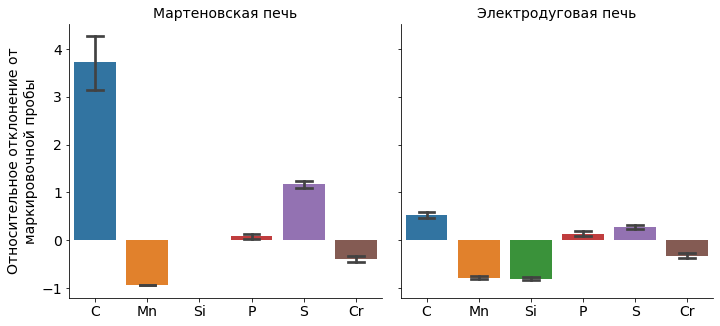

In [21]:
plt.rcParams['font.size'] = 14

g = sns.catplot(
    x='feature', y='deviation', col='furnace', kind ='bar', capsize=0.3, 
    data=deviation_long.query('sample == 0')\
    .replace({'open-hearth': 'Мартеновская печь', 'EAF': 'Электродуговая печь'})
)
g.set_axis_labels('', 'Относительное отклонение от\nмаркировочной пробы')\
.set_titles('{col_name}');

Шихта для мартеновской плавки содержит значительно больше C и S, и концентрация C варьируется в значительно бóльших пределах. В ходе плавки снижаются концентрации C, P, S, повышаются концентрации Mn, Si и Cr.

## Окисление углерода

In [22]:
data = data.assign(deoxid = lambda x: x.C_0 - x.C_1)

In [23]:
deox_subset = data.query('defect_risk == "high"')[['furnace', 'deoxid', 'defect_rate']]

for furnace in data.furnace.unique():
    frame = deox_subset.query('furnace == @furnace').drop('furnace', axis=1)
    idx = frame.index[frame.apply(lambda x: check_outliers(x), axis=0).apply(any, axis=1)]
    deox_subset = deox_subset.drop(idx, axis=0)

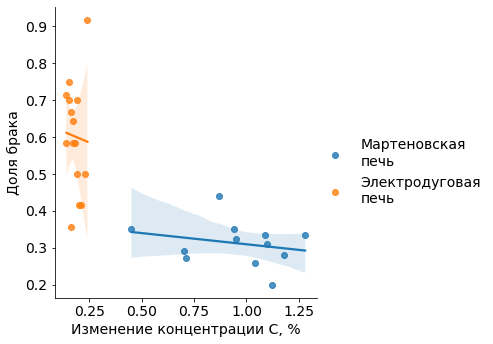

In [24]:
g = sns.lmplot(
    x='deoxid', y='defect_rate', hue='furnace', 
    data=deox_subset.replace({'furnace': {'open-hearth': 'Мартеновская\nпечь', 'EAF': 'Электродуговая\nпечь'}})
)
g.set_axis_labels('Изменение концентрации C, %', 'Доля брака').legend.set_title('')

In [25]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [26]:
deox_lm = ols(formula='defect_rate ~ deoxid * furnace', data=data).fit()
print(sm.stats.anova_lm(deox_lm, typ=2))

                  sum_sq    df         F    PR(>F)
furnace         0.172618   1.0  3.089397  0.084269
deoxid          0.009204   1.0  0.164724  0.686391
deoxid:furnace  0.150256   1.0  2.689183  0.106638
Residual        3.128963  56.0       NaN       NaN


Технология проведения кипа не оказывает значимого влияния на долю брака.

## Десульфурация

In [27]:
data = data.assign(desulf = lambda x: x.S_0 - x.S_1)

In [28]:
desulf_subset = data.query('defect_risk == "high"')[['furnace', 'desulf', 'defect_rate']]

for furnace in data.furnace.unique():
    frame = desulf_subset.query('furnace == @furnace').drop('furnace', axis=1)
    idx = frame.index[frame.apply(lambda x: check_outliers(x), axis=0).apply(any, axis=1)]
    desulf_subset = desulf_subset.drop(idx, axis=0)

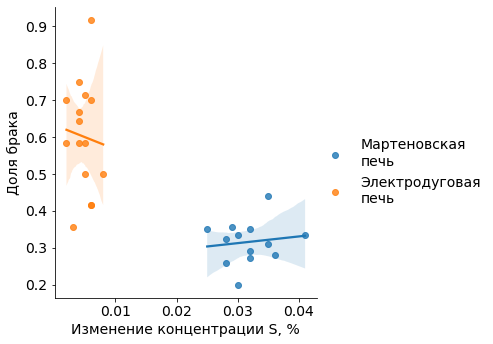

In [29]:
g = sns.lmplot(
    x='desulf', y='defect_rate', hue='furnace', 
    data=desulf_subset.replace({'furnace': {'open-hearth': 'Мартеновская\nпечь', 'EAF': 'Электродуговая\nпечь'}}))
g.set_axis_labels('Изменение концентрации S, %', 'Доля брака').legend.set_title('')

In [30]:
desulf_lm = ols(formula='defect_rate ~ desulf * furnace', data=data).fit()
print(sm.stats.anova_lm(desulf_lm, typ=2))

                  sum_sq    df         F    PR(>F)
furnace         0.150761   1.0  2.669714  0.107885
desulf          0.065136   1.0  1.153449  0.287434
desulf:furnace  0.060922   1.0  1.078825  0.303425
Residual        3.162365  56.0       NaN       NaN


Технология десульфурации не оказывает значимого влияния на долю брака.

## Изменение состава при выпуске металла из печи

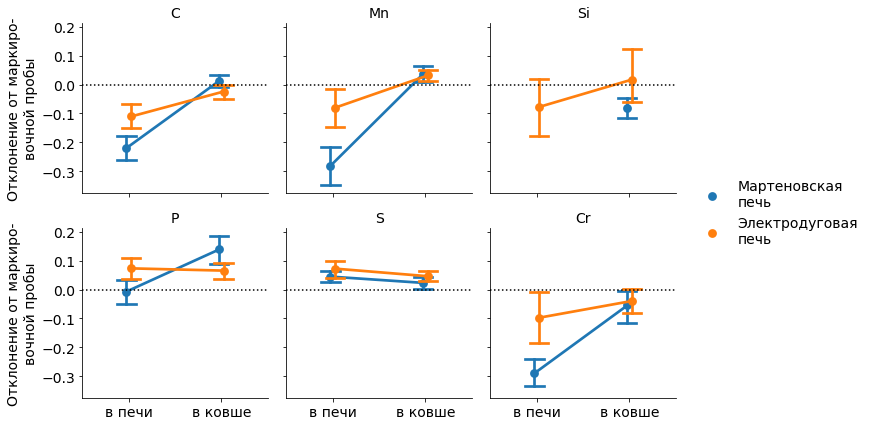

In [31]:
g = sns.catplot(
    x='sample', y='deviation', col='feature', hue='furnace', kind='point',
    capsize=0.2, height=3.2, aspect=1, col_wrap=3, dodge=True,
    data=deviation_long.query('sample > 1')\
    .replace({'furnace': {'open-hearth': 'Мартеновская\nпечь', 'EAF': 'Электродуговая\nпечь'},
              'sample': {2: 'в печи', 3: 'в ковше'}}))
g.map(plt.axhline, y=0, c='k', ls=":")
g.set_axis_labels('', 'Отклонение от маркиро-\nвочной пробы').legend.set_title('')
g.set_titles('{col_name}');

При выпуске из печи повышается средняя концентрация C, Mn, Si и Cr, снижается средняя концентрация S. В мартеновской стали повышается концентрация P. 

In [32]:
from itertools import product

frame = deviation_long.query('sample > 1').drop(['melt_id', 'defect_risk'], axis=1).dropna()
res = []

for par in product(frame.furnace.unique(), frame.feature.unique()):
    try:
        stat, p, test = diff_test(
            frame.query('furnace == @par[0] & feature == @par[1] & sample == 2').deviation,
            frame.query('furnace == @par[0] & feature == @par[1] & sample == 3').deviation)
    except IndexError:
        continue
    
    par += test, stat, p,
    res.append(par)
    
res = pd.DataFrame(res, columns=['furnace', 'feature', 'test', 'stat', 'p_value'])
reject, p_adjust, a1, a2 = multipletests(res.p_value, alpha = 0.05, method = 'fdr_bh')
res = res.assign(p_adjust=p_adjust, null_reject=reject)

with pd.option_context('precision', 2):
    print(res.sort_values(['feature', 'furnace'], ascending=False))

        furnace feature          test    stat   p_value  p_adjust  null_reject
7           EAF      Si  Mannwhitneyu  368.50  2.31e-01  2.82e-01        False
3   open-hearth       S  Mannwhitneyu  522.00  2.73e-01  3.00e-01        False
9           EAF       S  Mannwhitneyu  575.50  6.36e-02  1.00e-01        False
2   open-hearth       P  Mannwhitneyu  169.00  3.28e-05  9.03e-05         True
8           EAF       P  Mannwhitneyu  478.00  6.84e-01  6.84e-01        False
1   open-hearth      Mn  Mannwhitneyu   38.00  1.17e-09  6.45e-09         True
6           EAF      Mn  Mannwhitneyu  234.50  1.48e-03  2.71e-03         True
4   open-hearth      Cr  Mannwhitneyu   81.00  6.46e-08  2.37e-07         True
10          EAF      Cr  Mannwhitneyu  336.00  9.07e-02  1.25e-01        False
0   open-hearth       C         Ttest   -9.82  6.01e-14  6.61e-13         True
5           EAF       C  Mannwhitneyu  215.50  4.85e-04  1.07e-03         True


Значимо различаются концентрации C и Mn не зависимо от способа плавки, а также концентрация Cr и P – в стали мартеновский плавки.

## Угар раскислителей

In [33]:
alloy_comp = pd.DataFrame({'Mn': [70, 78, 0, 0, 0, 0], 
                           'Si': [17, 0, 45, 53, 4.5, 0], 
                           'Ti': [0, 0, 0, 0, 30, 0], 
                           'Al': [0, 0, 0, 0, 0, 87]}, 
                          index=['FeSiMn', 'FeMn', 'FeSi', 'CaSi', 'FeTi', 'AB']).replace(0, np.nan)

absorb_exp = []

for furnace in data.furnace.unique():
    frame = data.query('furnace == @furnace')
    absorb = {}
    
    for feature in alloy_comp.columns:
        alloys = alloy_comp[feature].dropna().index
        absorb[feature] = np.dot(frame[alloys].fillna(0), alloy_comp[feature].dropna()) / frame['melt_volume'] / 1000
    
    absorb_exp.append(pd.DataFrame(absorb).replace(0, np.nan))
    
absorb_fact = pd.DataFrame(
    np.hstack([data[['Mn_3', 'Si_3']].values - data[['Mn_2', 'Si_2']].fillna(0.01).values,
               data[['Ti_3', 'Al_3']].values]), 
    columns=['Mn', 'Si', 'Ti', 'Al'])

absorb_rate = pd.DataFrame(
    absorb_fact.values / pd.concat(absorb_exp, axis=0).values, 
    columns=absorb_fact.columns)\
.mask(lambda x: x > 1.05, np.nan)\
.mask(lambda x: x < 0, np.nan)\
.merge(data[['furnace', 'defect_rate', 'defect_risk']], left_index=True, right_index=True)

absorb_rate_long = pd.melt(absorb_rate, 
                        value_vars=list(absorb_rate.columns), 
                        id_vars=['furnace', 'defect_rate', 'defect_risk'], 
                        var_name='feature', 
                        value_name='absorb_rate')

with pd.option_context('precision', 2):
    print(absorb_rate_long.sample(5))

         furnace  defect_rate defect_risk feature  absorb_rate
121  open-hearth         0.02         low      Ti         0.49
24   open-hearth         0.28        high      Mn         0.63
123  open-hearth         0.02         low      Ti         0.52
42           EAF         0.08         low      Mn          NaN
180  open-hearth         0.02         low      Al         0.39
